# Initialization

In [28]:
import itertools
import os
from pathlib import Path
from pandas import Series, DataFrame

for folder in itertools.chain([Path.cwd()], Path.cwd().parents):
    if (folder / 'Pipfile').exists():
        os.chdir(folder)
        break


from sklearn.model_selection import cross_validate
from cache import save_data, load_data

from evaluation_functions import join_repeats_and_folds_cv_results
from formatting import format_list
from notebooks.heart_transplant.dependencies.heart_transplant_functions import format_feature, format_feature_with_code
from notebooks.heart_transplant.dependencies.heart_transplant_pipelines import get_logistic_regression_pipeline, \
    get_random_forest_pipeline
from utils import map_index
from visualisation import plot_feature_importance

from matplotlib import pyplot as plt
from nested_cv import evaluate_simple_cross_validation, StaticHyperParameters, SimpleEvaluationProtocol, \
    get_cv_results_from_simple_cv_evaluation
from notebooks.heart_transplant.dependencies.heart_transplant_data import *

%load_ext autoreload
%autoreload 2
%load_ext autotime
%config InlineBackend.figure_format = 'retina'

plt.style.use('seaborn')

X = X_reduced
y = y_reduced


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The autotime extension is already loaded. To reload it, use:
  %reload_ext autotime
time: 14 ms (started: 2021-02-02 17:04:05 +01:00)


In [3]:
results_rf = load_data('heart_transplant_feature_importance_xgboost_results')
results_xgboost = load_data('heart_transplant_feature_importance_rf_results')

time: 68.2 ms (started: 2021-02-01 11:49:36 +01:00)


In [4]:
results_rf = evaluate_simple_cross_validation(
    partial(get_random_forest_pipeline, features=X.columns),
    X,
    y,
    StaticHyperParameters({}),
    SimpleEvaluationProtocol(repeats=1, cv=10, stratified=True),
    parallel=False,
    feature_names=X.columns,
)

.
.
.
.
.
.
.
.
.
.

time: 2min 30s (started: 2021-02-01 10:48:33 +01:00)


In [5]:
results_xgboost = evaluate_simple_cross_validation(
    lambda: get_xgboost_pipeline(features=X.columns),
    X,
    y,
    StaticHyperParameters({}),
    SimpleEvaluationProtocol(repeats=1, cv=10, stratified=True),
    parallel=False,
    feature_names=X.columns,
)

.
.
.
.
.
.
.
.
.
.

time: 22min 3s (started: 2021-02-01 10:51:04 +01:00)


In [13]:
save_data('heart_transplant_feature_importance_xgboost_results', results_xgboost)
save_data('heart_transplant_feature_importance_rf_results', results_rf)

time: 42 ms (started: 2021-02-01 11:18:33 +01:00)


In [52]:
def print_top_features(results, n_features: int):
    _feature_importance = join_repeats_and_folds_cv_results(get_cv_results_from_simple_cv_evaluation(results))['feature_importance']
    print(list(_feature_importance.iloc[:n_features].index))

def plot_features(results, n_features: int = None):
    _feature_importance = join_repeats_and_folds_cv_results(get_cv_results_from_simple_cv_evaluation(results))['feature_importance']
    _feature_importance = map_index(partial(format_feature, metadata), _feature_importance)
    plot_feature_importance(_feature_importance, n_features)

time: 997 µs (started: 2021-02-01 12:30:58 +01:00)


**TOP 40 features (Random Forest)**

In [7]:
print_top_features(results_rf, 40)

['log_ischtime', 'log_tbili', 'log_creat_trr', 'log_cmassratio', 'hist_mi', 'weight ratio', 'congenital', 'ecd_donor', 'log_wgt_kg_calc', 'log_sgpt_don', 'log_sgot_don', 'log_wgt_kg_don_calc', 'log_age_don', 'log_distance', 'log_age', 'cdc_risk_hiv_don', 'log_hgt_cm_calc', 'log_hgt_cm_don_calc', 'log_bun_don', 'coronary_angio', 'log_tbili_don', 'tattoos', 'biopsy_dgn', 'log_creat_don', 'vessels_50sten', 'log_most_rcnt_creat', 'lv_eject', 'education', 'retransplant', 'log_newpra', 'protein_urine', 'hematocrit_don', 'iabp_tcr', 'hist_iv_drug_old_don', 'hiv_serostatus', 'gender', 'cmv_status', 'hemo_co_tcr', 'impl_defibril', 'hist_hypertens_don']
time: 93.7 ms (started: 2021-02-01 11:13:07 +01:00)


**TOP 40 features (XGBoost)**

**XGBoost**

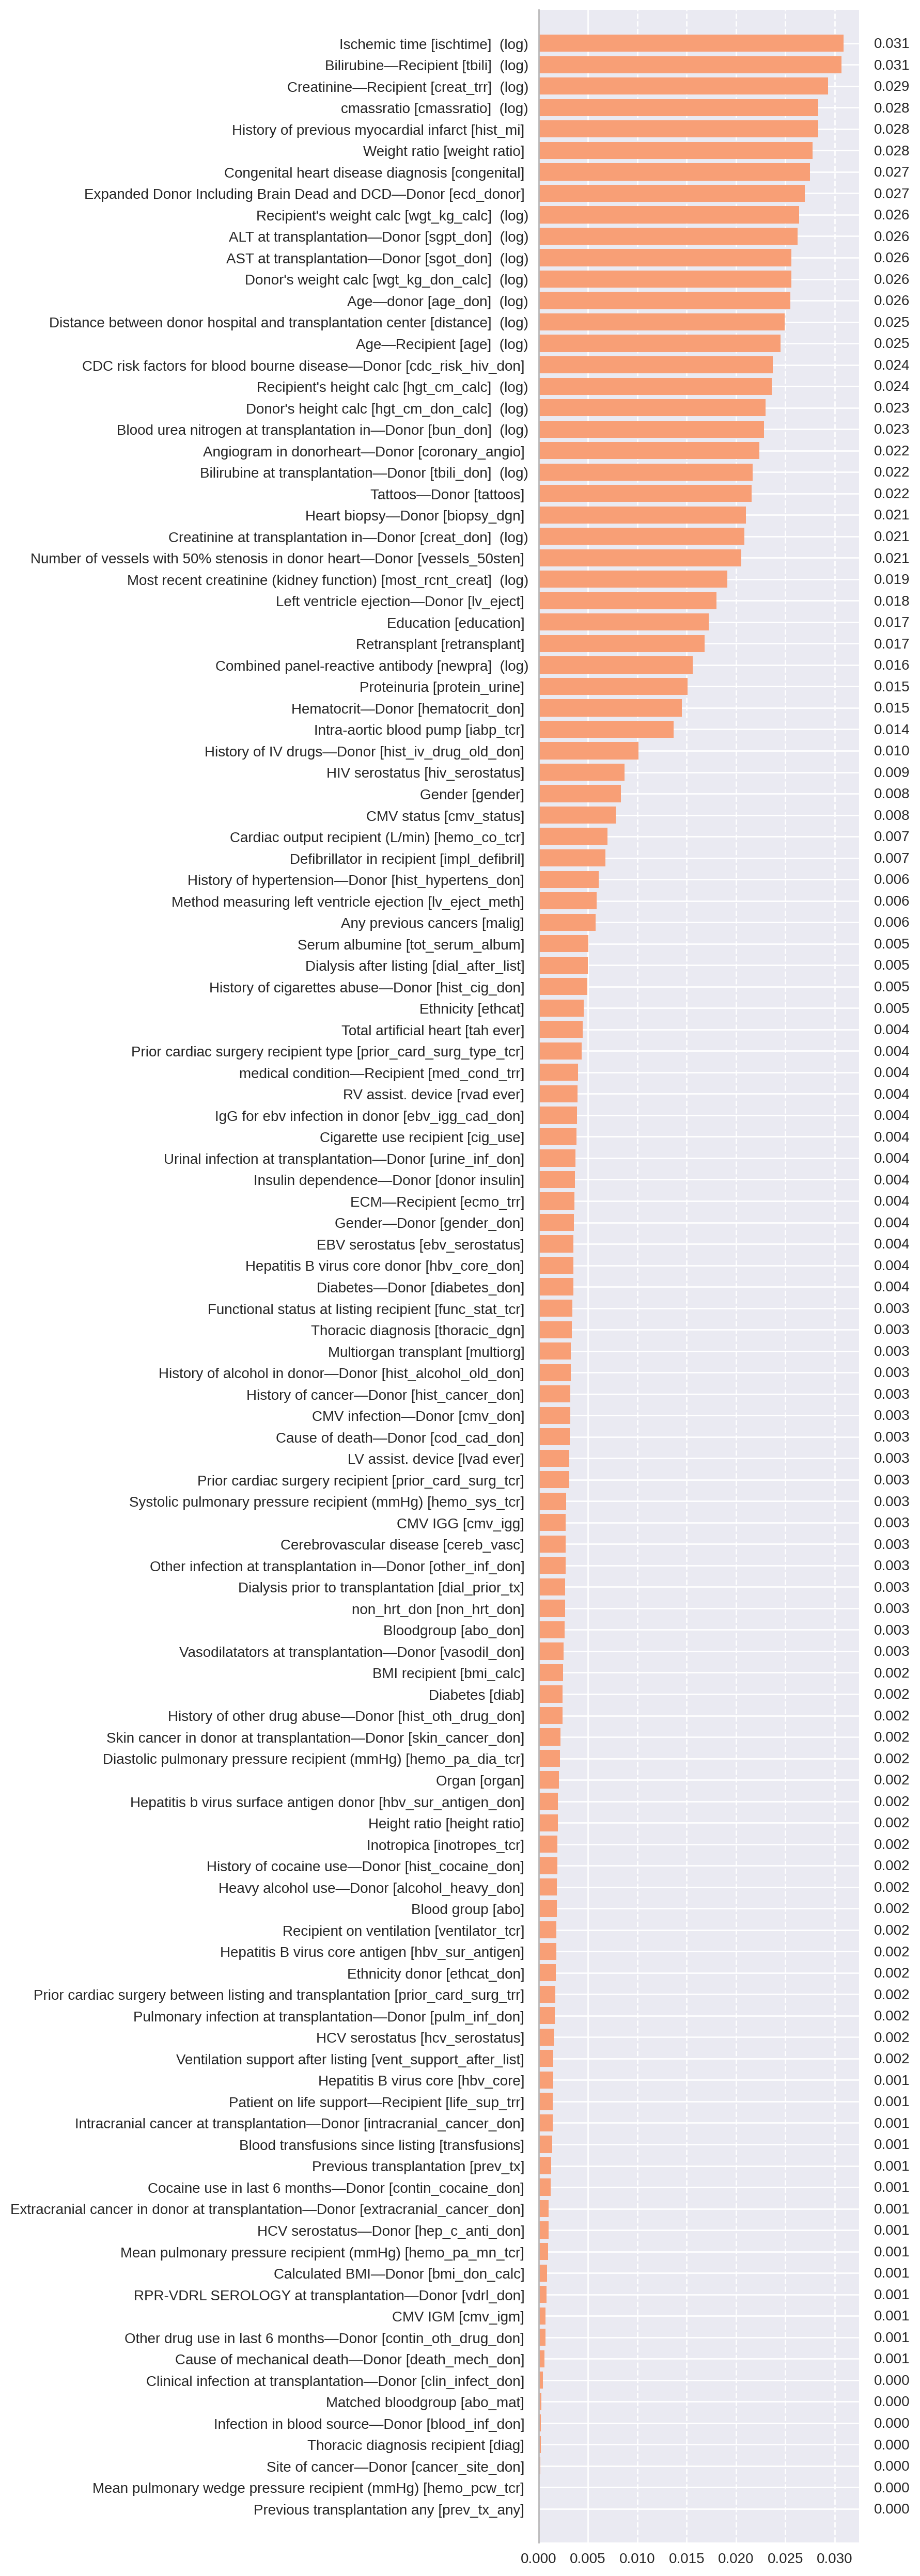

time: 7.9 s (started: 2021-02-01 12:29:58 +01:00)


In [49]:
plot_features(results_xgboost)
plt.savefig('././data/heart_transplant/feature_importance_xgboost.png', facecolor='white', bbox_inches="tight", dpi=300)

**Random forest**

116


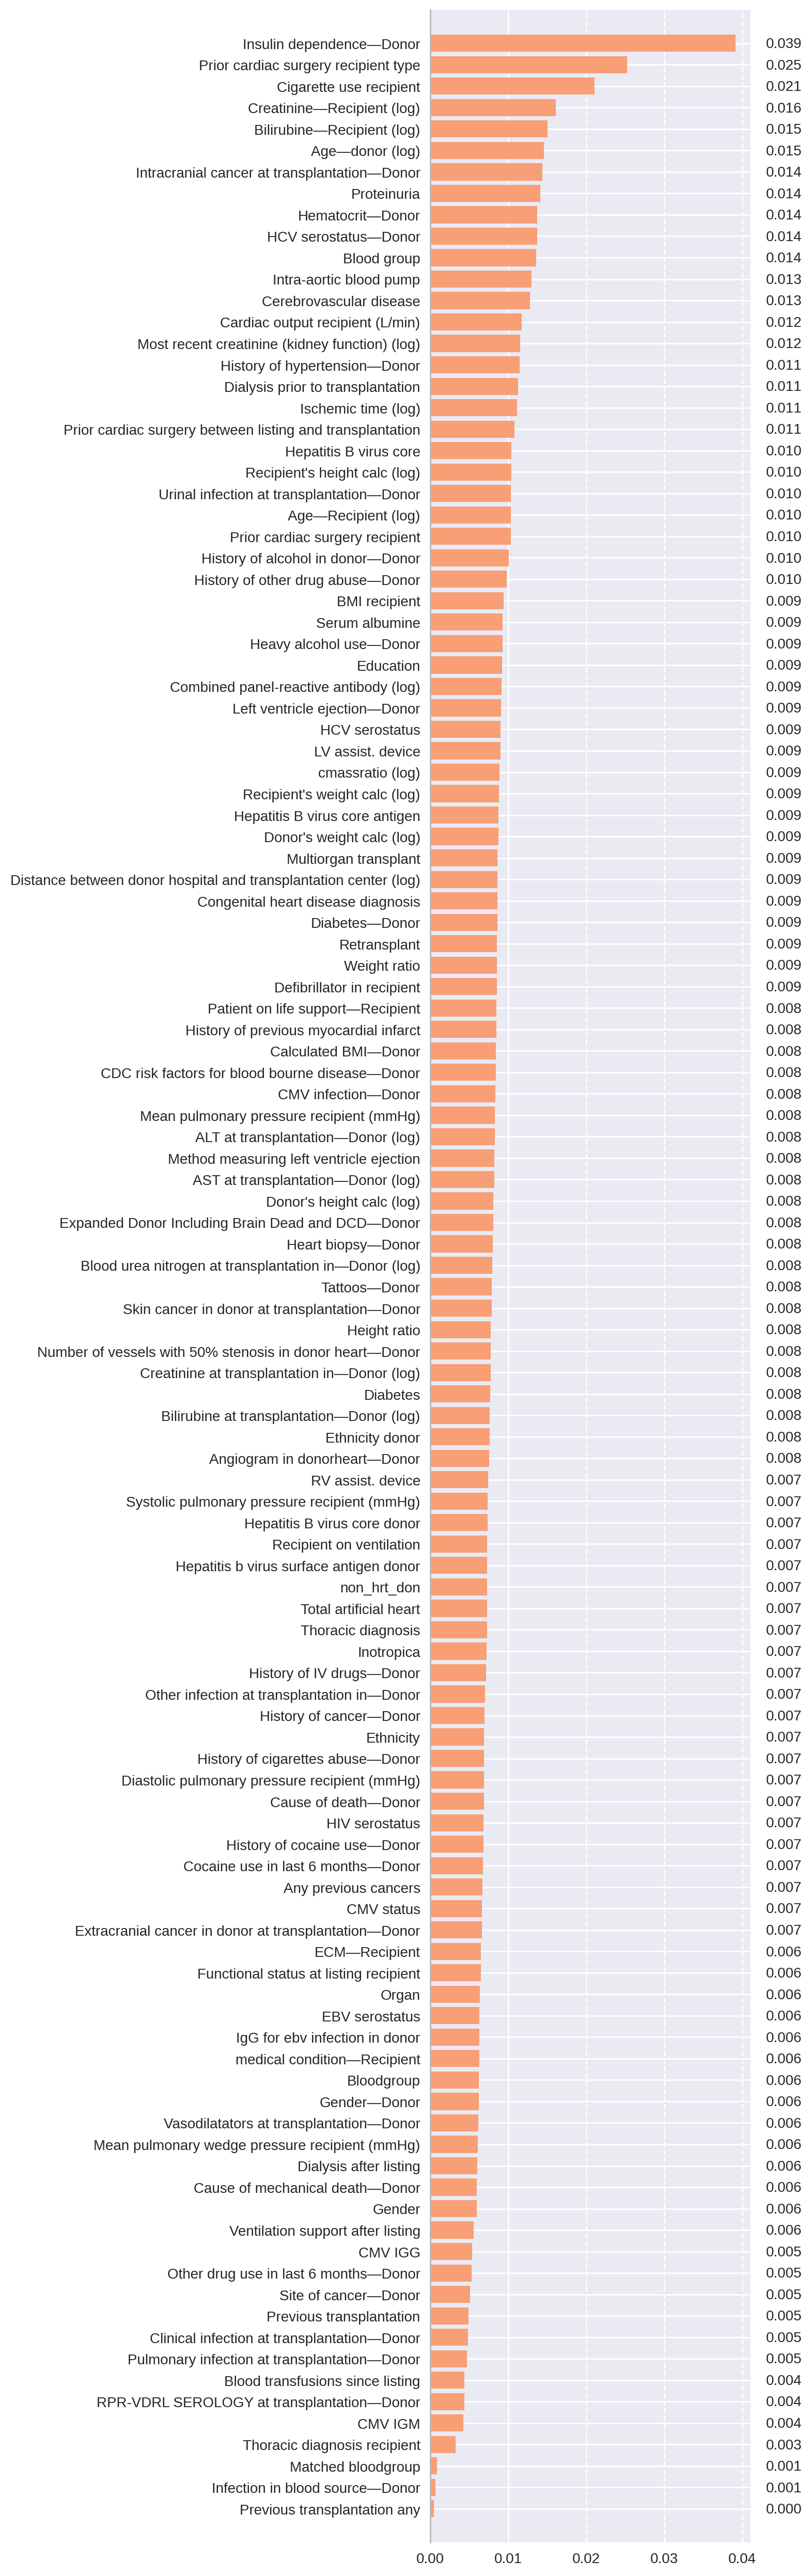

time: 6.62 s (started: 2021-02-01 12:31:01 +01:00)


In [53]:
plot_features(results_rf)
plt.savefig('././data/heart_transplant/feature_importance_rf.png', facecolor='white', bbox_inches="tight", dpi=300)

In [6]:
results_lr = cross_validate(get_logistic_regression_pipeline(X, y, features=X.columns), X, y, cv=10, return_estimator=True, n_jobs=-1)

time: 1min 30s (started: 2021-02-02 16:24:06 +01:00)


In [38]:
coefficients = DataFrame(
    {'coef': results_lr['estimator'][0][-1].coef_[0]},
    index=list(map(partial(format_feature_with_code, metadata), X.columns))
)

pandas.set_option('display.max_rows', 500)

coefficients.reindex(coefficients.abs().sort_values(by='coef', ascending=False).index)

,coef
Recipient's weight calc [wgt_kg_calc] (log),-0.513018
History of previous myocardial infarct [hist_mi],0.323635
Donor's weight calc [wgt_kg_don_calc] (log),-0.320700
Age—Recipient [age] (log),0.314288
Age—donor [age_don] (log),0.250645
Bilirubine—Recipient [tbili] (log),0.206158
Creatinine—Recipient [creat_trr] (log),0.196459
Ventilation support after listing [vent_support_after_list],0.183757
Intracranial cancer at transplantation—Donor [intracranial_cancer_don],-0.131004
Intra-aortic blood pump [iabp_tcr],-0.120276


time: 11.1 ms (started: 2021-02-02 17:07:15 +01:00)


In [62]:
feature_importance = join_repeats_and_folds_cv_results(get_cv_results_from_simple_cv_evaluation(results_xgboost))['feature_importance']

print("\n".join(list(map(partial(format_feature_with_code, metadata), feature_importance.index))))

Ischemic time [ischtime] (log)
Bilirubine—Recipient [tbili] (log)
Creatinine—Recipient [creat_trr] (log)
cmassratio [cmassratio] (log)
History of previous myocardial infarct [hist_mi]
Weight ratio [weight ratio]
Congenital heart disease diagnosis [congenital]
Expanded Donor Including Brain Dead and DCD—Donor [ecd_donor]
Recipient's weight calc [wgt_kg_calc] (log)
ALT at transplantation—Donor [sgpt_don] (log)
AST at transplantation—Donor [sgot_don] (log)
Donor's weight calc [wgt_kg_don_calc] (log)
Age—donor [age_don] (log)
Distance between donor hospital and transplantation center [distance] (log)
Age—Recipient [age] (log)
CDC risk factors for blood bourne disease—Donor [cdc_risk_hiv_don]
Recipient's height calc [hgt_cm_calc] (log)
Donor's height calc [hgt_cm_don_calc] (log)
Blood urea nitrogen at transplantation in—Donor [bun_don] (log)
Angiogram in donorheart—Donor [coronary_angio]
Bilirubine at transplantation—Donor [tbili_don] (log)
Tattoos—Donor [tattoos]
Heart biopsy—Donor [biopsy